## 1.1 Import Libraries

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


np.random.seed(1)
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


## 1.2 Data Dictionary

Data fields
Input variables:

### 1.2a Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### 1.2b Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


### 1.2c Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


### 1.2d social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target): 
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## 2.0 Import Data set

In [2]:
raw_data= pd.read_csv('./datasets/train.csv',sep=";")

## 2.1 Data Preprocessing

In [3]:
raw_data.columns, raw_data.shape

(Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
       dtype='object'), (2999, 21))

In [4]:
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## 2.2 Feature Engineering

In [5]:
data=raw_data.copy()

### 2.2a Convert unknown values in housing loan to 'no'

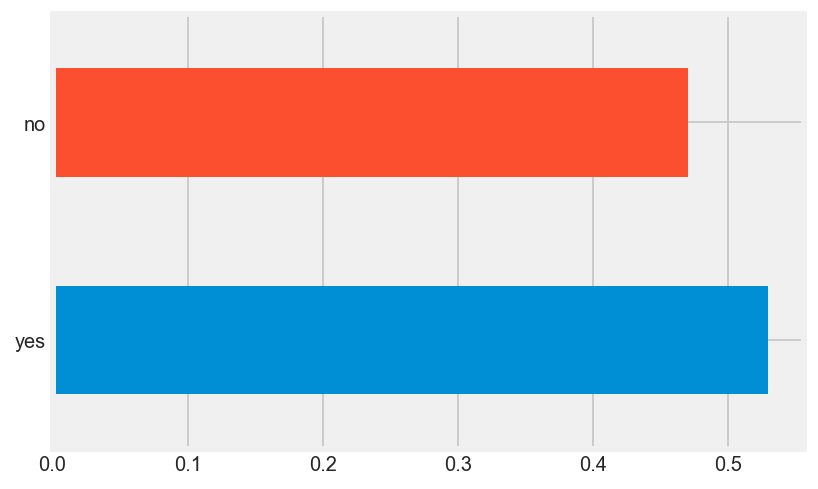

In [6]:
#data.marital.value_counts(normalize=True)
data.housing=data['housing'].replace({'unknown': 'no'})
data.housing.value_counts(normalize=True).plot(kind='barh')

### 2.2b Combining all basic education levels to basic

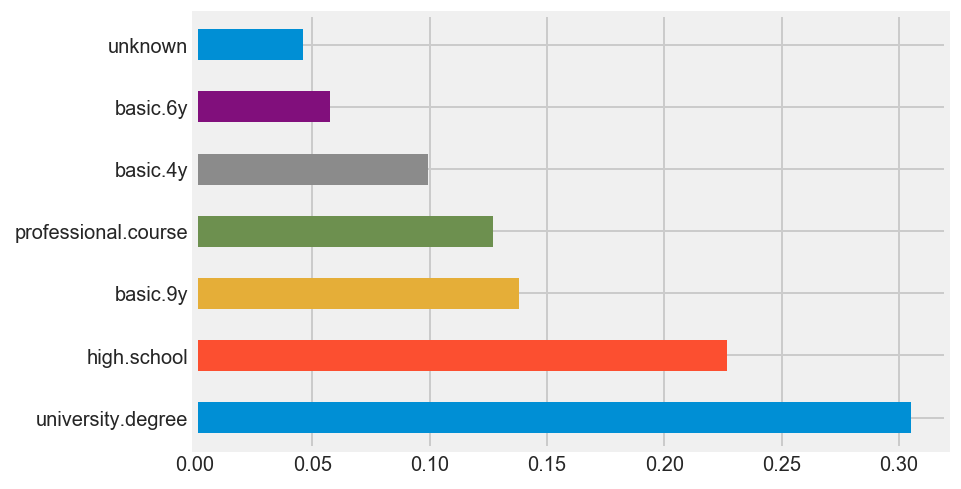

In [7]:
data.education.value_counts(normalize=True).plot(kind='barh')

In [8]:
#Let us group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.

data['education']=np.where(data['education'] =='basic.9y', 'basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'basic', data['education'])

data.education=data['education'].replace({'unknown': 'professional.course'})

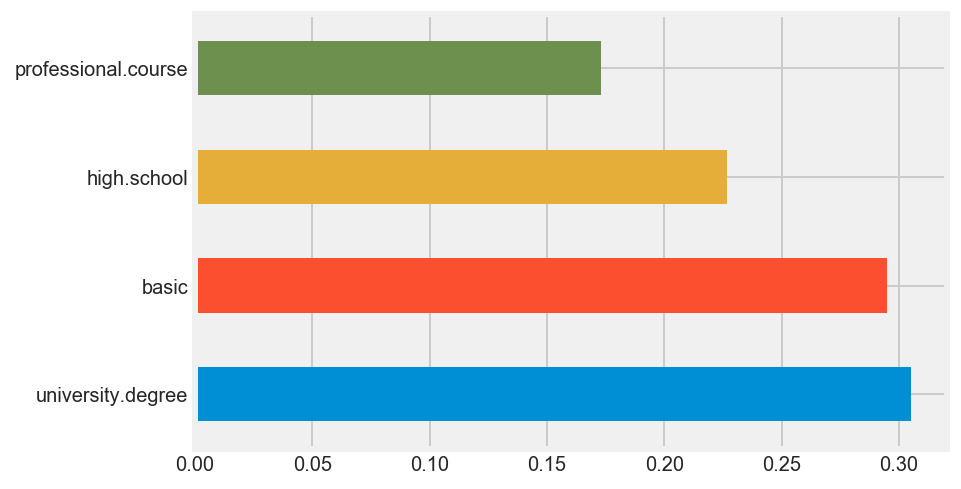

In [9]:
data.education.value_counts(normalize=True).plot(kind='barh')

### 2.2c Convert all pdays with value 999 -->0

In [10]:
data.pdays.value_counts()

999    2888
3        39
6        28
4        10
7         8
10        5
5         4
12        4
2         3
15        2
1         2
18        2
11        1
9         1
16        1
0         1
Name: pdays, dtype: int64

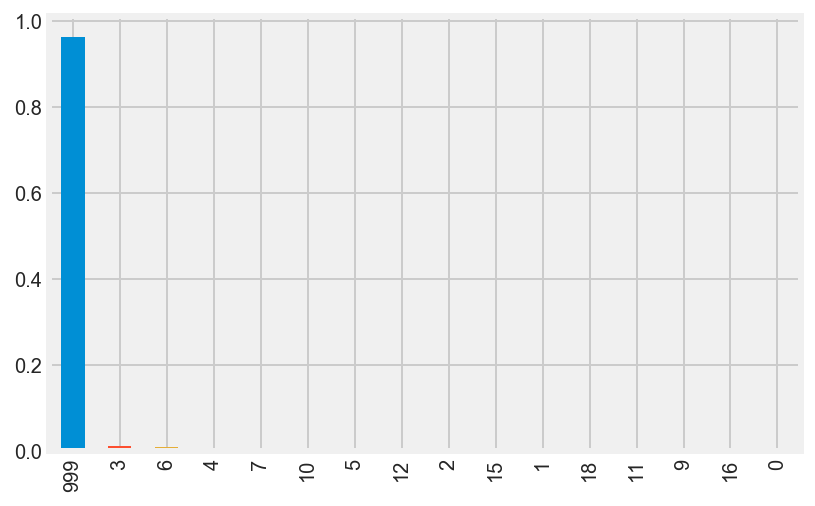

In [11]:
data.pdays.value_counts(normalize=True).plot(kind='bar')

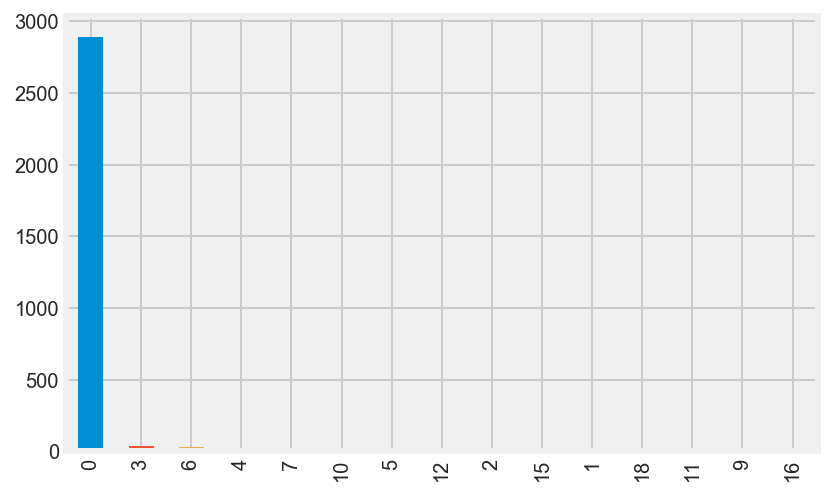

In [12]:
data.pdays=data.pdays.map(lambda x: 0 if x == 999 else x)
data.pdays.value_counts().plot(kind='bar')

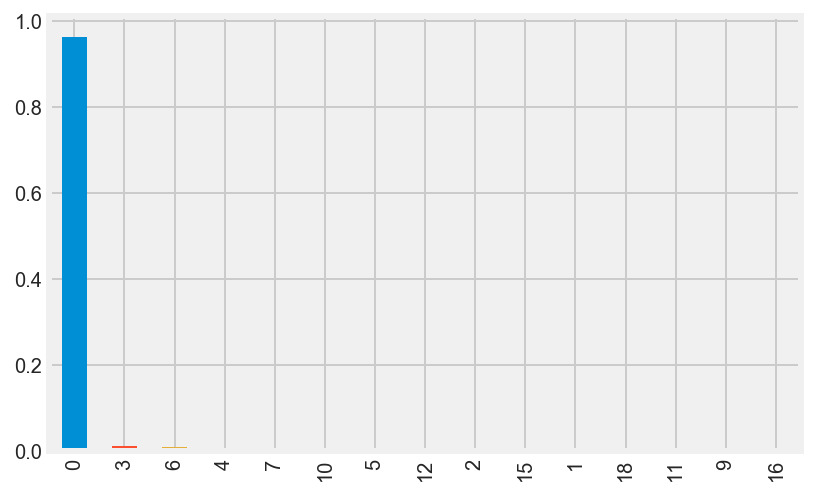

In [13]:
data.pdays.value_counts(normalize=True).plot(kind='bar')

### 2.2d Convert all default values to digits

In [14]:

data.default.value_counts(normalize=True)


no         0.801267
unknown    0.198733
Name: default, dtype: float64

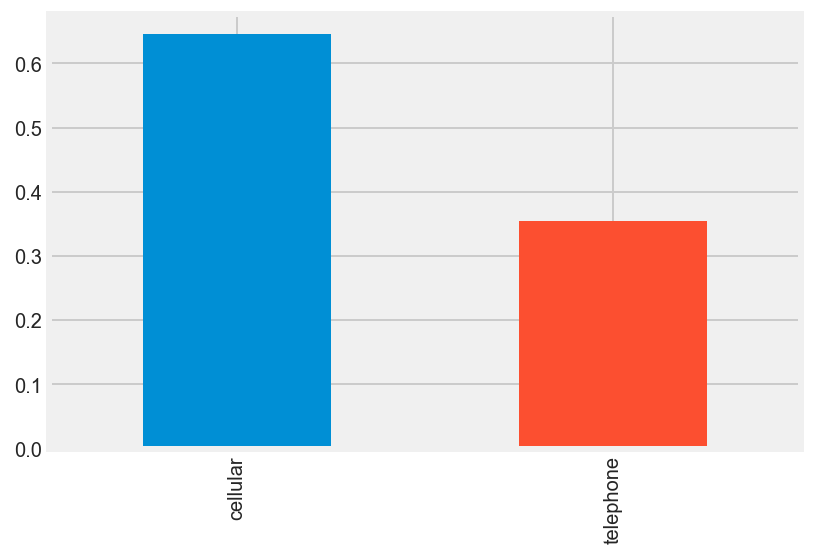

In [15]:
data.contact.value_counts(normalize=True).plot(kind='bar')

### 2.2e Plot all house loans values and replace unknown with no

In [16]:
#data.housing.value_counts(normalize=True)
data.housing=data['housing'].replace({'unknown': 'no'})
data.housing.value_counts()

yes    1589
no     1410
Name: housing, dtype: int64

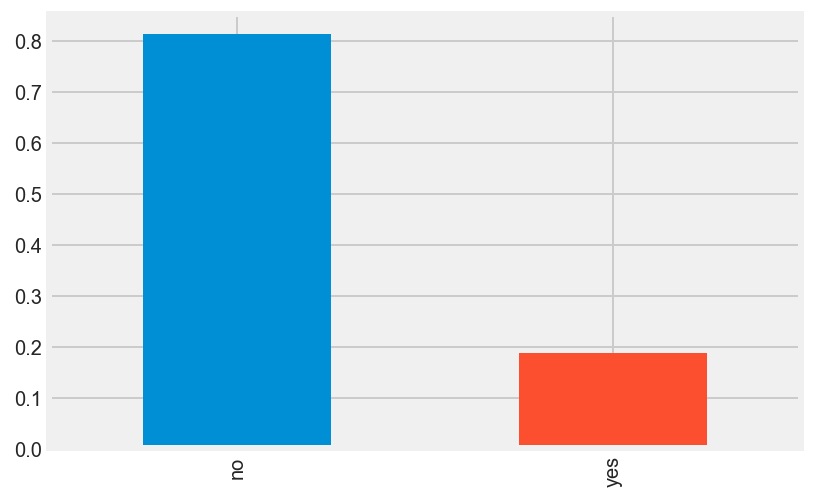

In [17]:
data.loan.value_counts(normalize=True)
data.loan=data['loan'].replace({'unknown': 'yes'})
data.loan.value_counts(normalize=True).plot(kind='bar')

### 2.2f Plot all job types to digits and replace unknows with admin

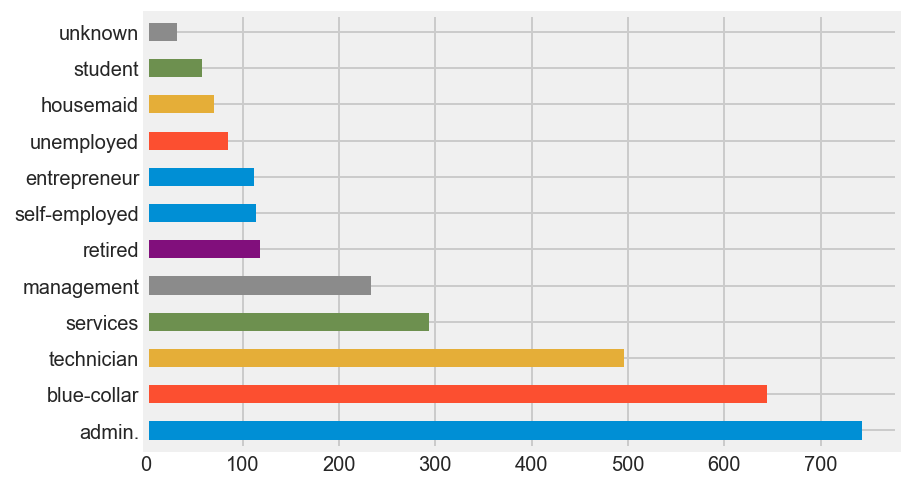

In [18]:
data.job.value_counts().plot(kind='barh')

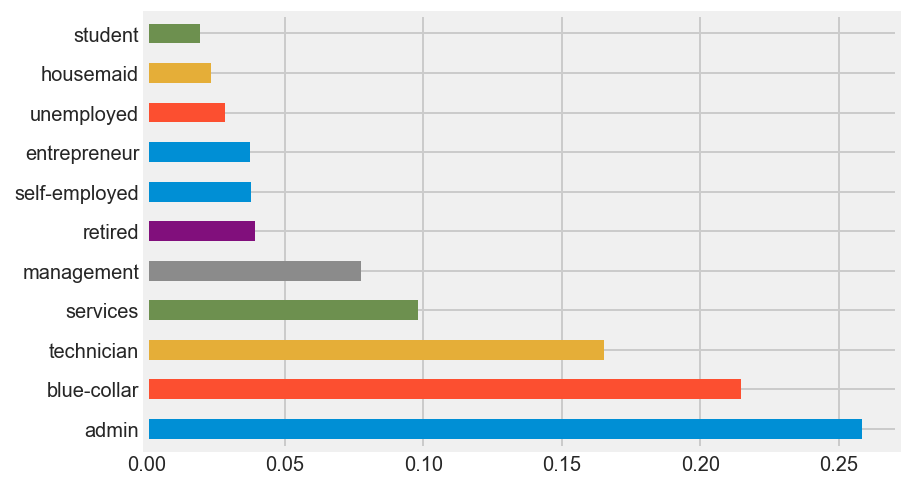

In [19]:
data.job=data['job'].replace({'unknown': 'admin.'})
data.job=data['job'].replace({'admin.': 'admin'})
data.job.value_counts(normalize=True).plot(kind='barh')

### 2.2g Plot marital and  replace unknows values with divorced

In [20]:
data.marital.value_counts(normalize=True)

married     0.604201
single      0.285428
divorced    0.107369
unknown     0.003001
Name: marital, dtype: float64

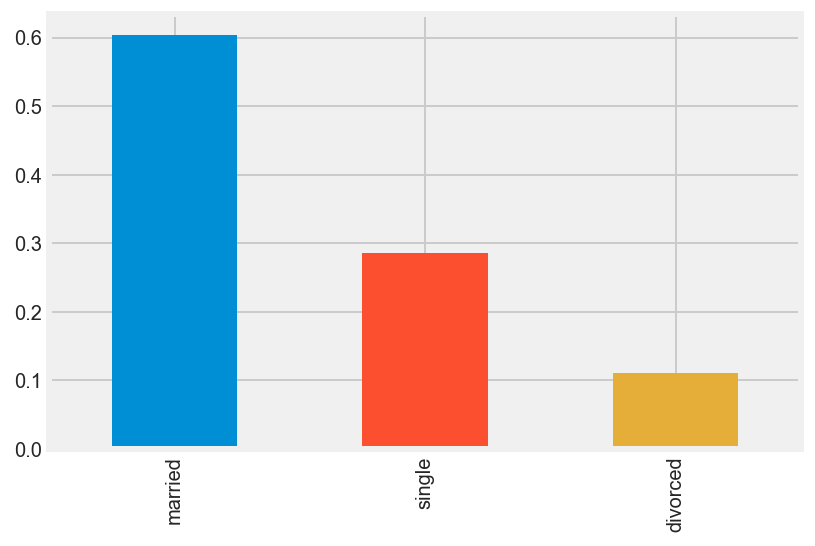

In [21]:
data.marital=data['marital'].replace({'unknown': 'divorced'})
data.marital.value_counts(normalize=True).plot(kind='bar')#, 'b': 'y', 'c': 'w', 'd': 'z'})

### 2.2h Converting and Plotting the target variable 

In [22]:
data.y=data.y.map(lambda x: 1 if x == 'yes' else 0)

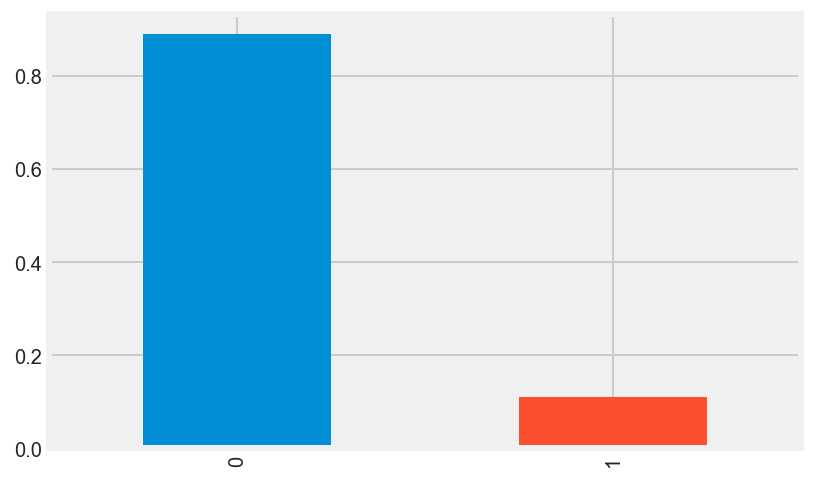

In [23]:
data.y.value_counts(normalize=True).plot(kind='bar')

### 2.2h Ploting the outcome of the previous campaign

<function matplotlib.pyplot.show>

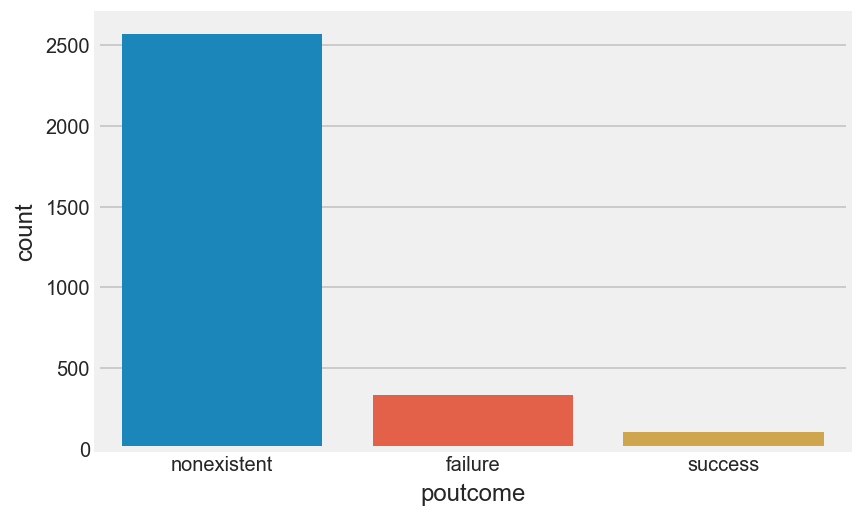

In [24]:
sns.countplot(x="poutcome",data=data)
plt.show

### 2.3 Checking if there is any null value

In [25]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### 2.4 Renaming the features

In [26]:
data.rename(columns={'default': 'have_credit_by_default','housing':'housing_loan',
                     'loan':'personal_loan','contact':'communication_type','day_of_week':'last_contact_day',
                     'duration':'last_contact_duration','campaign':'no_contact_with_client',
                     'poutcome':'outcome_previous_campaign','pdays':'n_days_clcontact_prev_campaign','previous':'no_contct_bef_campaign_wth_samepersn'}, inplace=True)
data.rename(columns={
        'emp.var.rate':'employee_variatn_rate',
        'cons.price.idx':'consmr_price_indx',
        'nr.employed': 'nr_employees',
        'cons.conf.idx':'conmrs_confidnc_indx'
            }, inplace=True)
#rename variables to be able to analyse

### 2.5. removing variables beacuase of high VIF( check Capstoen Project-Multicollinearity)

In [27]:
col_del=['nr_employees','euribor3m','outcome_previous_campaign']#,'outcome_previous_campaign']

data.drop(columns=col_del,inplace=True)

### 2.6.a Look for outliers

In [28]:
data.dtypes



age                                       int64
job                                      object
marital                                  object
education                                object
have_credit_by_default                   object
housing_loan                             object
personal_loan                            object
communication_type                       object
month                                    object
last_contact_day                         object
last_contact_duration                     int64
no_contact_with_client                    int64
n_days_clcontact_prev_campaign            int64
no_contct_bef_campaign_wth_samepersn      int64
employee_variatn_rate                   float64
consmr_price_indx                       float64
conmrs_confidnc_indx                    float64
y                                         int64
dtype: object

### 2.6.b Check the box plots for non string variables

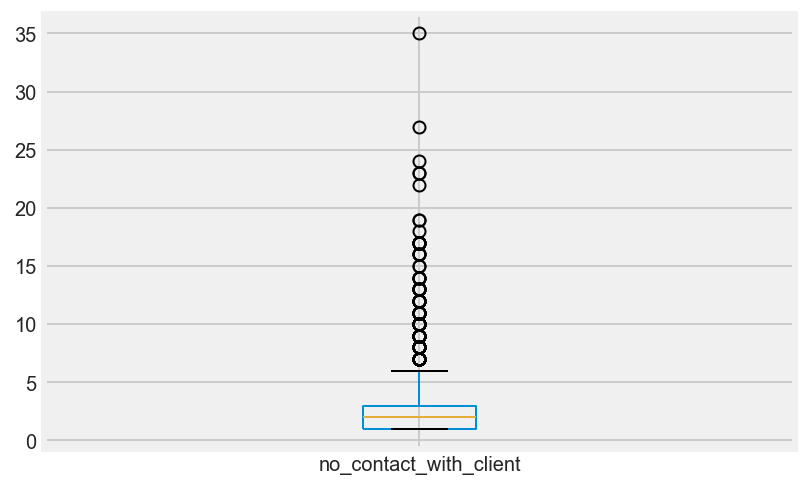

In [29]:
data.boxplot(column=['no_contact_with_client'])

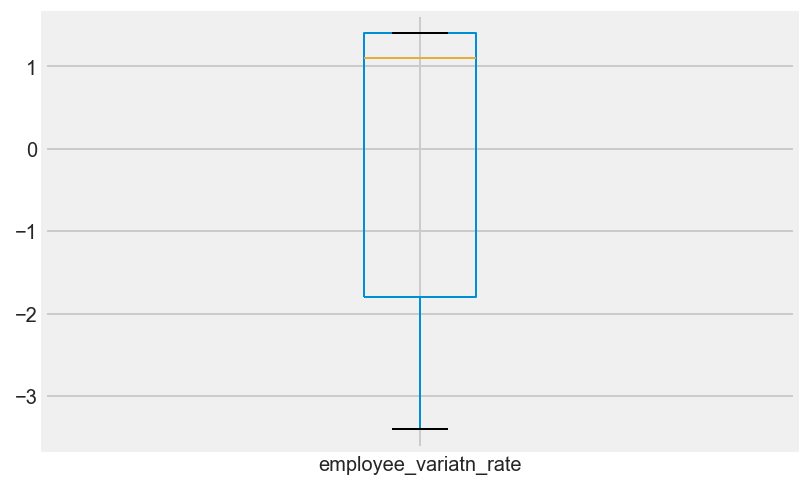

In [30]:
data.boxplot(column=['employee_variatn_rate'])

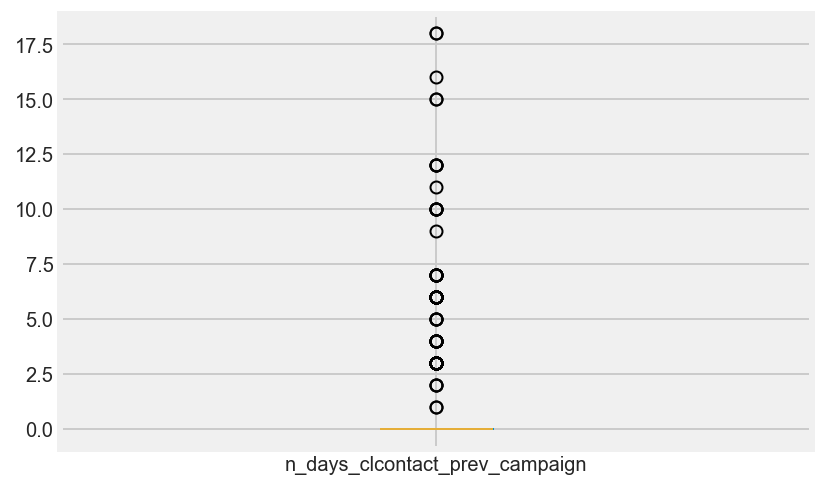

In [31]:
data.boxplot(column=['n_days_clcontact_prev_campaign'])

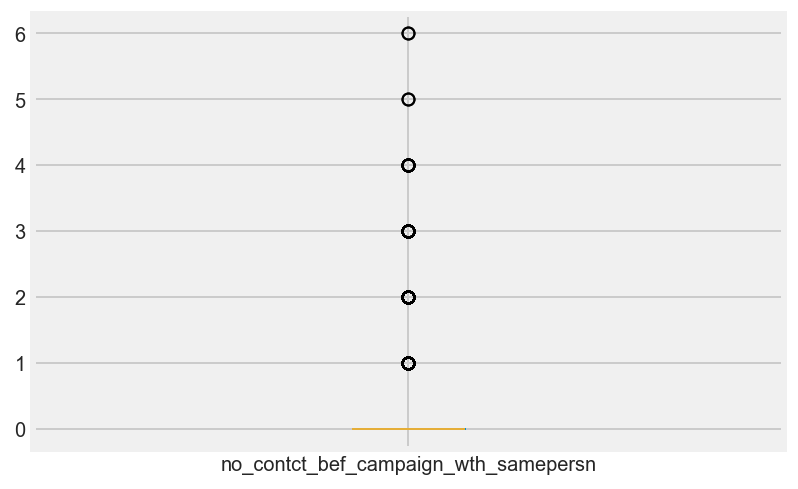

In [32]:
data.boxplot(column=['no_contct_bef_campaign_wth_samepersn'])

In [34]:
#If there's inflation—when goods and services costs more—the#The Consumer Price Index (CPI) is a measure that examines the weighted average of prices of a basket of consumer goods and services
#CPI will rise over a short period of time, say six to eight months. If the CPI declines, that means there's deflation, or a steady decrease in the prices of goods and services.
data.consmr_price_indx.value_counts()

93.994    551
93.918    489
92.893    458
93.444    375
94.465    313
93.200    274
93.075    140
92.963     52
92.201     50
94.199     30
92.431     30
94.027     26
92.649     25
94.215     24
94.767     22
92.379     20
94.055     18
94.601     17
92.843     15
93.876     15
93.369     14
92.713     13
93.749     11
92.469     11
93.798      5
92.756      1
Name: consmr_price_indx, dtype: int64

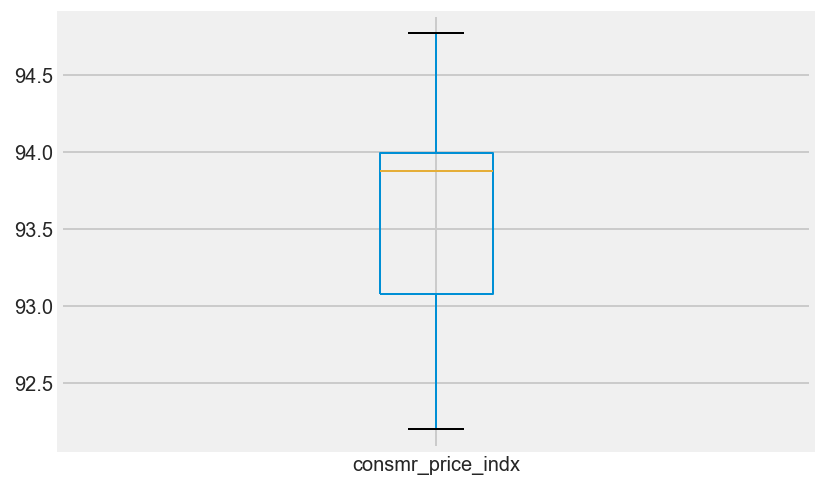

In [35]:
data.boxplot(column=['consmr_price_indx'])

In [36]:
data.conmrs_confidnc_indx.value_counts(normalize=True)
#the degree of optimism on the  economy that consumers are expressing through their activities of savings and spending.

-36.4    0.183728
-42.7    0.163054
-46.2    0.152718
-36.1    0.125042
-41.8    0.104368
-42.0    0.091364
-47.1    0.046682
-40.8    0.017339
-31.4    0.016672
-37.5    0.010003
-26.9    0.010003
-38.3    0.008670
-30.1    0.008336
-40.3    0.008003
-50.8    0.007336
-29.8    0.006669
-39.8    0.006002
-49.5    0.005669
-40.0    0.005002
-50.0    0.005002
-34.8    0.004668
-33.0    0.004335
-34.6    0.003668
-33.6    0.003668
-40.4    0.001667
-45.9    0.000333
Name: conmrs_confidnc_indx, dtype: float64

# 3. gain insight from the information

### 3.1.a.use mean to gain insight

In [37]:
data.groupby('age').mean().sort_values(by=['y'],ascending=False)
#The average age of customers who bought the term deposit is over 80 (babyboomers ) and is higher than that of the customers who didn’t.

,last_contact_duration,no_contact_with_client,n_days_clcontact_prev_campaign,no_contct_bef_campaign_wth_samepersn,employee_variatn_rate,consmr_price_indx,conmrs_confidnc_indx,y
age,,,,,,,,
86,275.500000,1.000000,3.500000,2.000000,-1.100000,94.199000,-37.500000,1.000000
82,279.000000,3.000000,3.000000,2.000000,-1.100000,94.199000,-37.500000,1.000000
81,617.000000,2.000000,0.000000,0.000000,-1.800000,92.893000,-46.200000,1.000000
80,382.000000,1.000000,3.000000,3.000000,-1.800000,93.876000,-40.000000,1.000000
68,546.000000,2.000000,0.000000,1.000000,-1.700000,94.215000,-40.300000,1.000000
75,169.000000,1.000000,0.000000,1.500000,-1.750000,93.645000,-43.700000,1.000000
76,292.250000,1.750000,2.250000,1.000000,-2.425000,93.233000,-34.900000,0.500000
73,157.000000,1.500000,0.000000,0.000000,-2.350000,92.522000,-40.700000,0.500000
21,384.166667,1.333333,0.000000,0.166667,-2.383333,93.168667,-37.466667,0.500000


In [38]:
data.groupby('no_contct_bef_campaign_wth_samepersn').mean().sort_values(by=['y'],ascending=False)

#The no_contct_bef_campaign_wth_samepersn is understandably higher for the customers who bought it. The higher the previous contact, the better the memory of the last call and hence the better chances of a sale. Maybe becasue consumer trust more


,age,last_contact_duration,no_contact_with_client,n_days_clcontact_prev_campaign,employee_variatn_rate,consmr_price_indx,conmrs_confidnc_indx,y
no_contct_bef_campaign_wth_samepersn,,,,,,,,
5,62.000000,564.000000,1.500000,4.000000,-1.100000,94.483000,-44.150000,1.000000
4,46.888889,295.888889,1.333333,5.333333,-1.655556,93.854111,-37.977778,0.888889
3,39.523810,331.857143,1.904762,4.380952,-1.723810,93.956714,-40.300000,0.666667
6,54.000000,186.000000,1.500000,3.000000,-1.400000,94.397000,-44.550000,0.500000
2,39.947368,255.666667,1.824561,2.456140,-2.021053,93.487088,-39.598246,0.333333
1,40.219941,257.290323,1.894428,0.923754,-1.713490,93.070144,-42.193548,0.208211
0,39.794312,253.821192,2.637320,0.000000,0.386755,93.649728,-40.390923,0.084145


In [39]:
data.groupby('n_days_clcontact_prev_campaign').mean().sort_values(by=['y'],ascending=False)
#the possibility of opening an acount if consumers have been approached between 5-10 days before the campaign seems lead to opening an account! 

,age,last_contact_duration,no_contact_with_client,no_contct_bef_campaign_wth_samepersn,employee_variatn_rate,consmr_price_indx,conmrs_confidnc_indx,y
n_days_clcontact_prev_campaign,,,,,,,,
5,43.250000,635.500000,2.250000,2.500000,-1.000000,94.197250,-45.850000,1.000000
10,42.800000,635.400000,2.000000,1.600000,-1.880000,93.395800,-39.560000,0.800000
3,44.307692,258.282051,1.512821,1.923077,-2.156410,93.262410,-37.805128,0.769231
7,40.750000,279.375000,1.250000,2.000000,-2.487500,93.340375,-34.350000,0.750000
6,41.178571,358.250000,2.107143,1.750000,-2.021429,93.595286,-37.632143,0.678571
12,40.000000,219.000000,2.250000,1.750000,-1.450000,93.907500,-45.325000,0.500000
15,31.000000,191.500000,2.000000,2.500000,-1.400000,94.207000,-38.900000,0.500000
18,33.000000,489.000000,2.500000,2.500000,-1.400000,94.113000,-37.900000,0.500000
4,38.900000,243.100000,1.300000,1.900000,-2.540000,92.976000,-35.520000,0.300000


In [40]:
data.groupby('job').mean().sort_values(by=['y'],ascending=False)

,age,last_contact_duration,no_contact_with_client,n_days_clcontact_prev_campaign,no_contct_bef_campaign_wth_samepersn,employee_variatn_rate,consmr_price_indx,conmrs_confidnc_indx,y
job,,,,,,,,,
retired,60.152542,324.025424,2.389831,0.381356,0.271186,-0.397458,93.547314,-39.427119,0.228814
student,26.482759,309.758621,1.982759,0.741379,0.482759,-1.053448,93.564914,-39.596552,0.206897
unemployed,40.164706,250.035294,2.694118,0.376471,0.223529,-0.184706,93.558271,-40.731765,0.164706
admin,38.256774,256.280000,2.627097,0.290323,0.197419,0.033548,93.534048,-40.108000,0.130323
technician,38.512097,250.993952,2.534274,0.233871,0.185484,0.244556,93.569919,-39.866129,0.122984
services,38.510204,222.714286,2.904762,0.091837,0.170068,0.088435,93.629150,-41.580272,0.088435
housemaid,44.628571,211.900000,2.514286,0.114286,0.157143,0.247143,93.618729,-39.645714,0.085714
management,42.188841,253.596567,2.394850,0.201717,0.257511,-0.066953,93.480300,-40.776824,0.081545
blue-collar,39.113354,260.465839,2.369565,0.083851,0.145963,0.214596,93.669674,-41.673137,0.077640


### 3.2.Visualisation

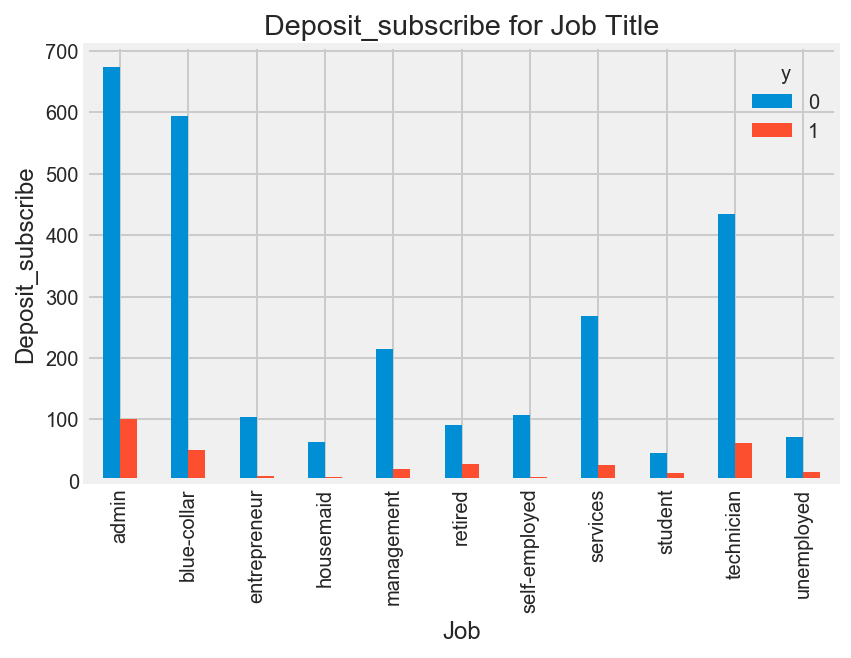

In [41]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Deposit_subscribe for Job Title')
plt.xlabel('Job')
plt.ylabel('Deposit_subscribe')
plt.savefig('subscribe_for_job')
#It seems job title is a good predictor of the target variable

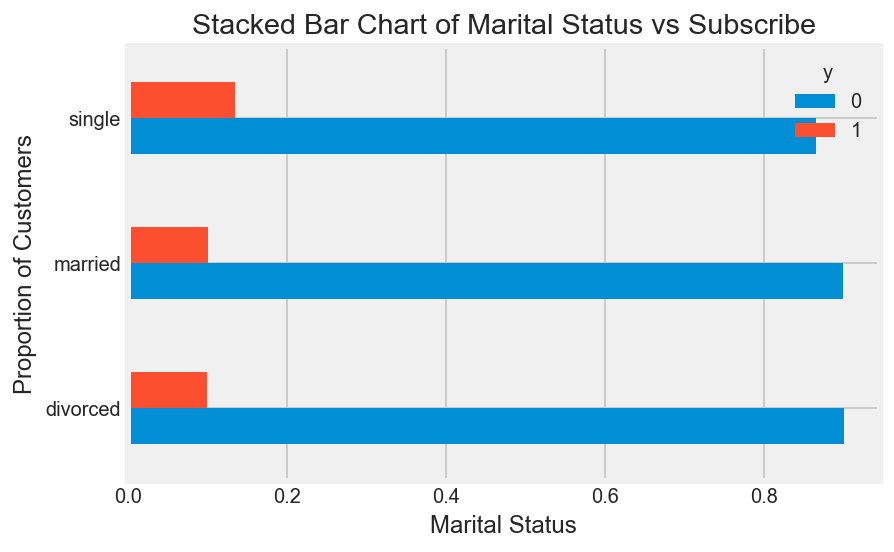

In [42]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='barh')
plt.title('Stacked Bar Chart of Marital Status vs Subscribe')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('marital_vs_pur_stack')
#The marital status does not seem a strong predictor for the outcome variable.

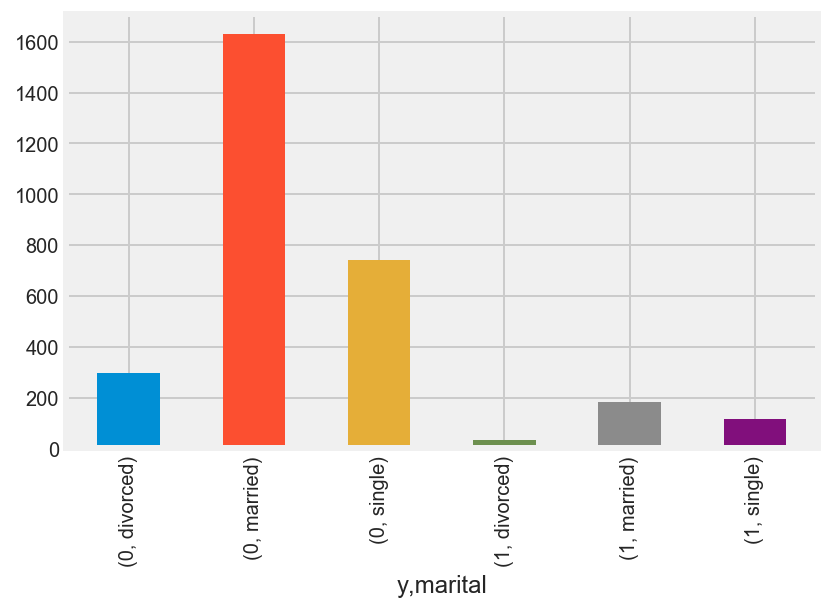

In [43]:
data.groupby(['y','marital'])['marital'].count().plot(kind='bar')

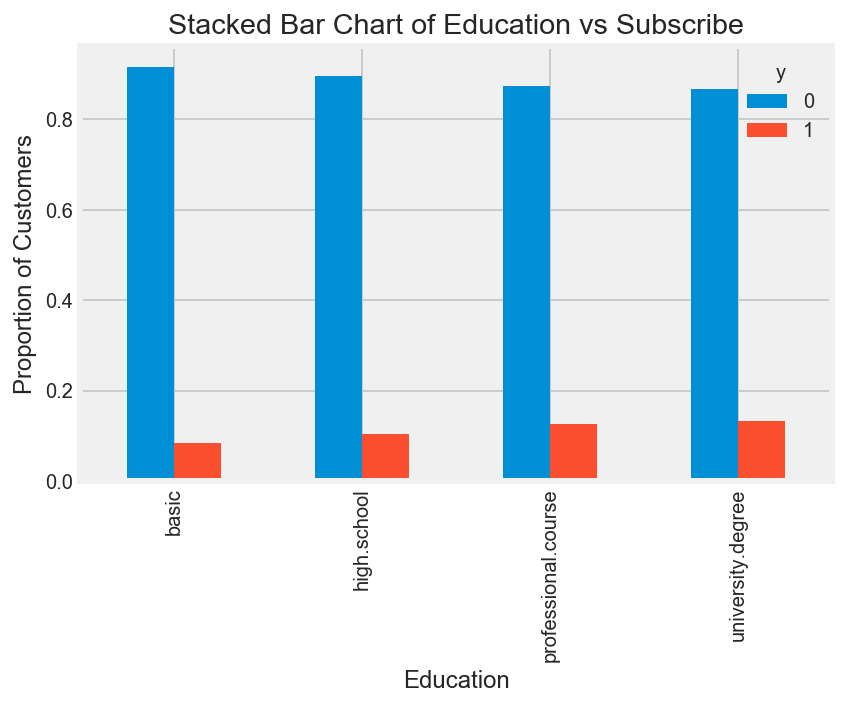

In [44]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of Education vs Subscribe')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')
#Education seems a good predictor of the outcome variable.

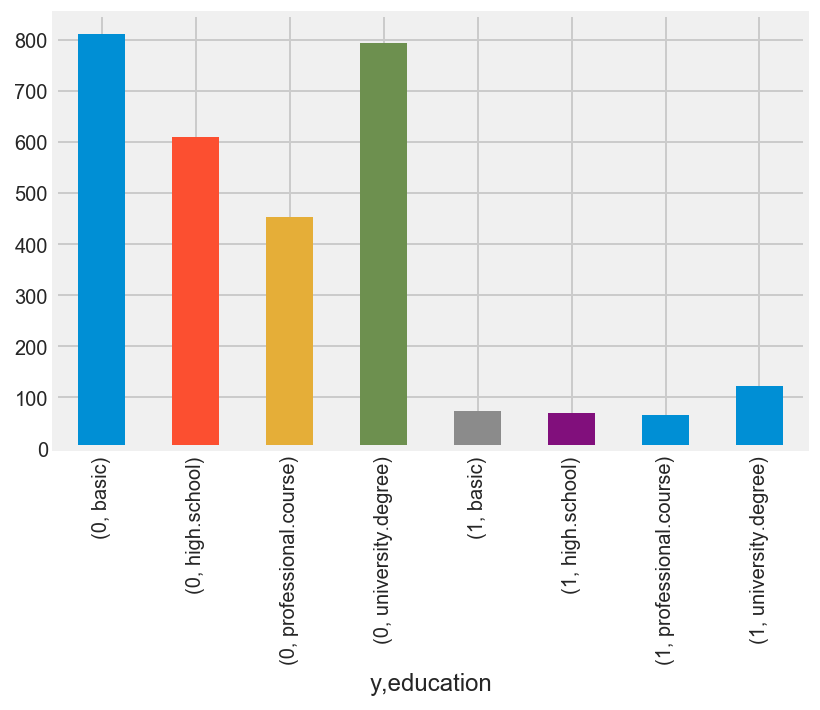

In [45]:
data.groupby(['y','education'])['education'].count().plot(kind='bar')

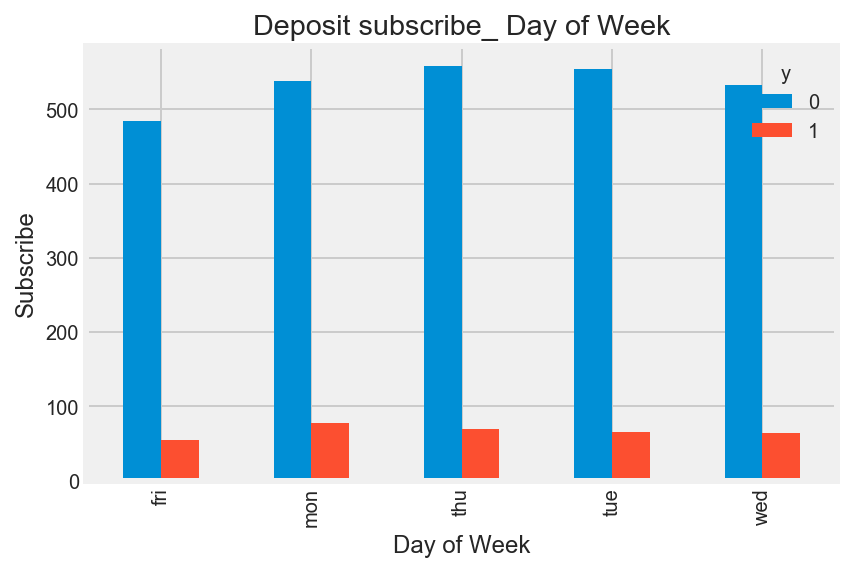

In [62]:
pd.crosstab(data.last_contact_day,data.y).plot(kind='bar')
plt.title('Deposit subscribe_ Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Subscribe')
plt.savefig('day of week_bar')
#Day of week may  be a good predictor of the outcome.

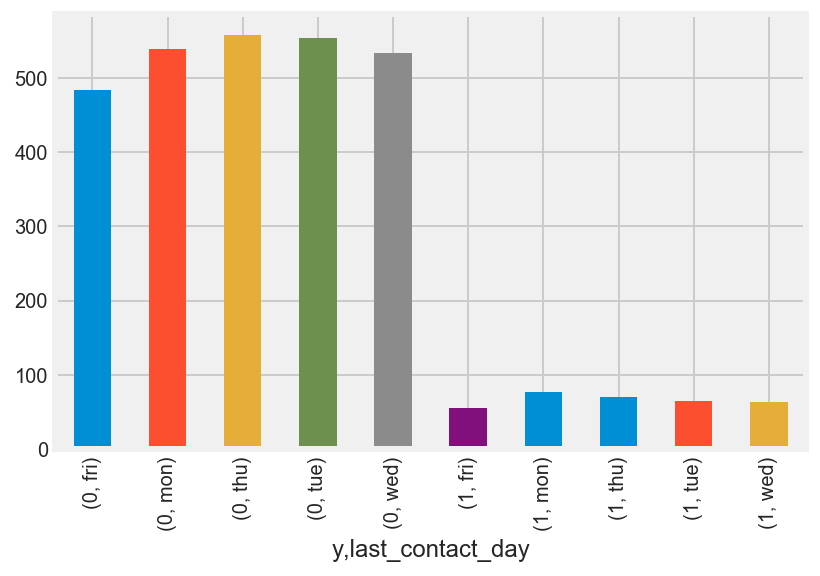

In [48]:
data.groupby(['y','last_contact_day'])['last_contact_day'].count().plot(kind='bar')
#To check if the days that customers were contacted is relatedd to the target variable

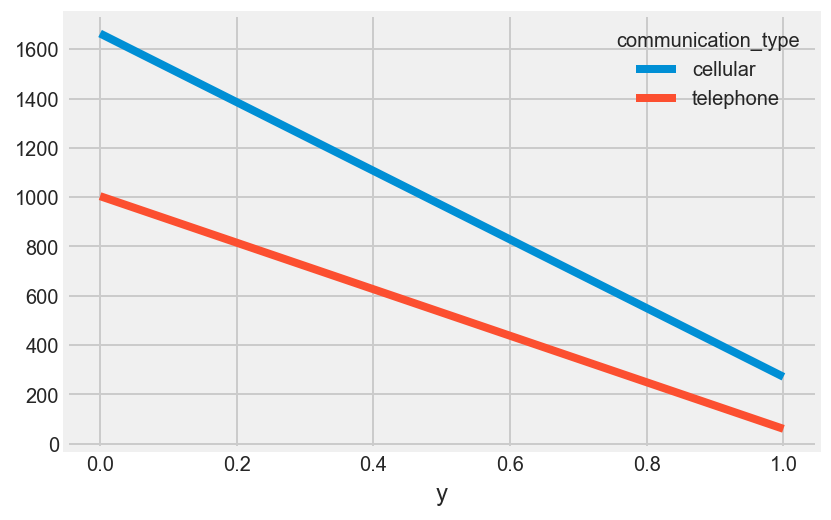

In [49]:
data.groupby(['y','communication_type'])['y'].count().unstack().plot()
#seems communication is also a good preditor of y as the number of deposits opens by individuals who have cellurar phones is more than the ones opened by telephone users. 

In [69]:
data[data.y==1].groupby(['y','last_contact_day','communication_type'])['y'].count().unstack()

communication_type  cellular  telephone
y last_contact_day                     
1 fri                     42         13
  mon                     68          9
  thu                     57         13
  tue                     54         11
  wed                     50         14

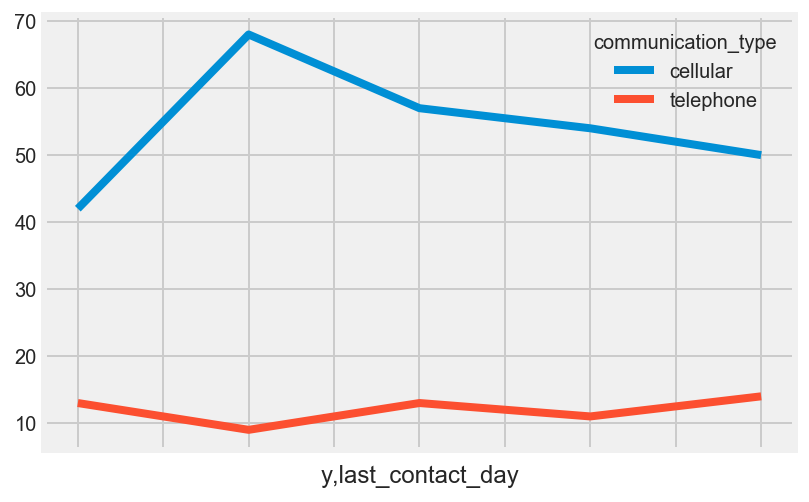

In [72]:
data[data.y==1].groupby(['y','last_contact_day','communication_type'])['y'].count().unstack().plot()

In [73]:
data[data.y==0].groupby(['y','last_contact_day','communication_type'])['y'].count().unstack()

communication_type  cellular  telephone
y last_contact_day                     
0 fri                    292        192
  mon                    331        208
  thu                    388        170
  tue                    334        220
  wed                    319        214

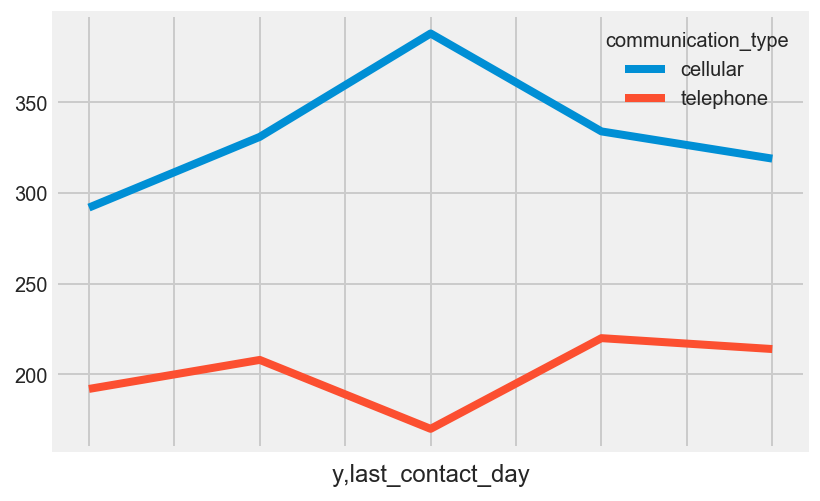

In [52]:
data[data.y==0].groupby(['y','last_contact_day','communication_type'])['y'].count().unstack().plot()

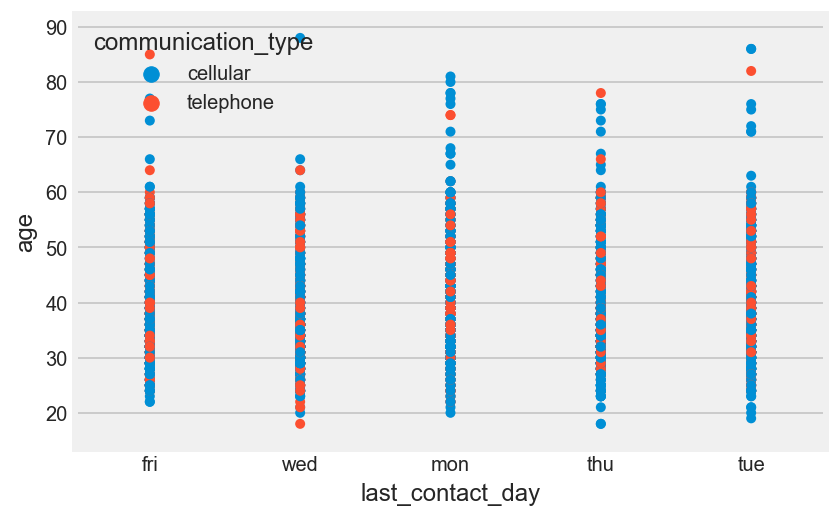

In [53]:
sns.stripplot(x='last_contact_day',y='age',hue='communication_type',data=data)

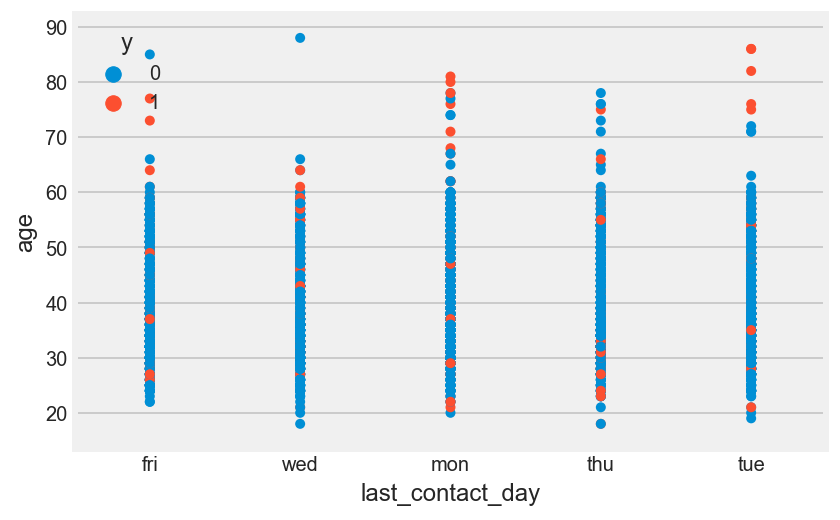

In [54]:
sns.stripplot(x='last_contact_day',y='age',hue='y',data=data)

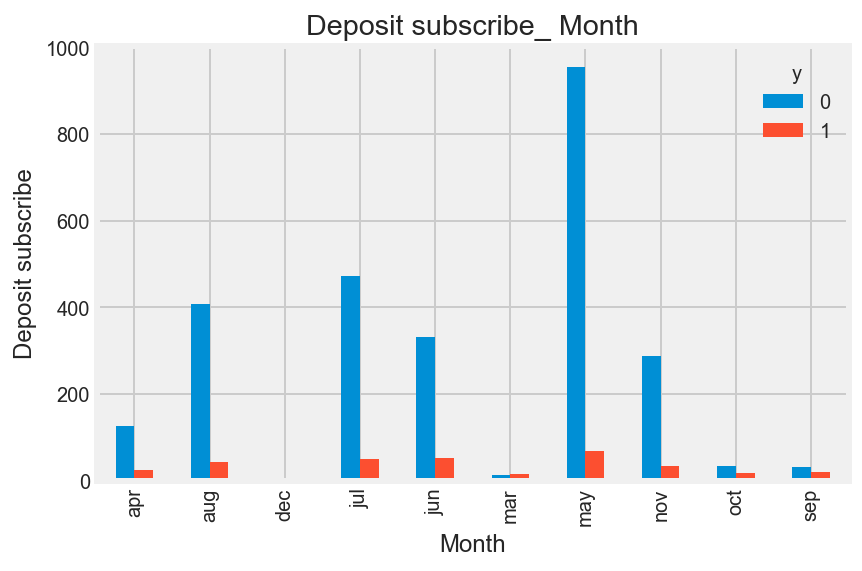

In [55]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Deposit subscribe_ Month')
plt.xlabel('Month')
plt.ylabel('Deposit subscribe')
plt.savefig('pur_fre_month_bar')
#Month might be a good predictor of the outcome variable.

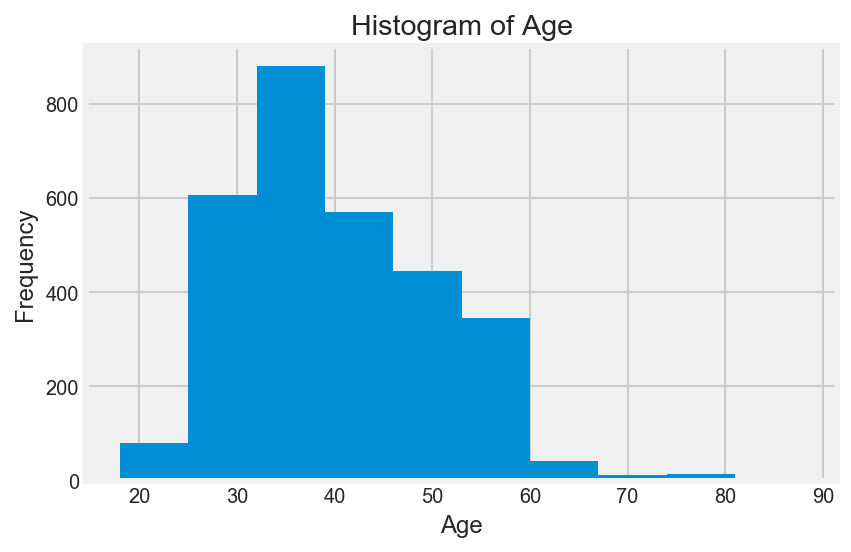

In [56]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')
#Most of the customers of the bank in this dataset are in the age range of 30–40.

In [57]:
data.columns

Index(['age', 'job', 'marital', 'education', 'have_credit_by_default',
       'housing_loan', 'personal_loan', 'communication_type', 'month',
       'last_contact_day', 'last_contact_duration', 'no_contact_with_client',
       'n_days_clcontact_prev_campaign',
       'no_contct_bef_campaign_wth_samepersn', 'employee_variatn_rate',
       'consmr_price_indx', 'conmrs_confidnc_indx', 'y'],
      dtype='object')

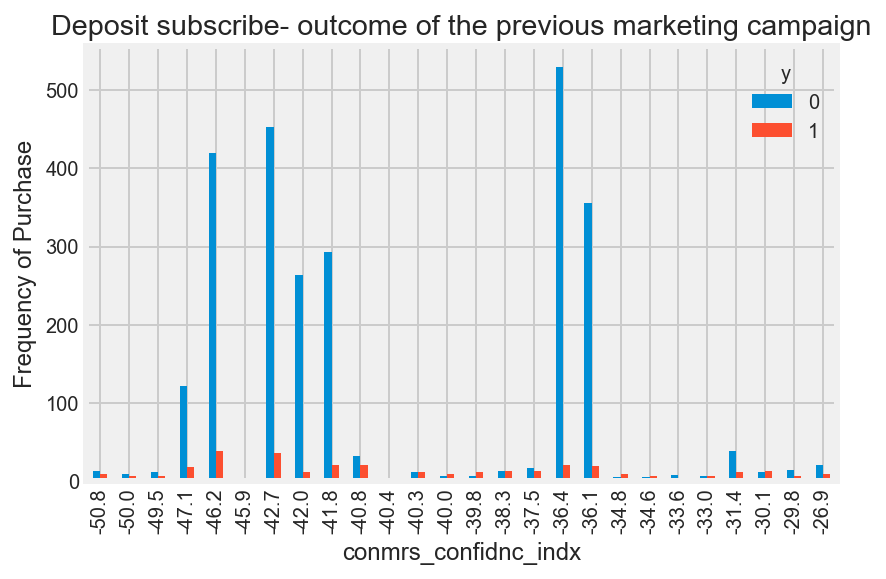

In [58]:
pd.crosstab(data.conmrs_confidnc_indx,data.y).plot(kind='bar')
plt.title('Deposit subscribe- outcome of the previous marketing campaign')
plt.xlabel('conmrs_confidnc_indx')
plt.ylabel('Frequency of Purchase')
plt.savefig('conmrs_confidnc_indx')
#conmrs_confidnc_indx seems to be a good predictor of the outcome variable.

In [59]:
### 3.-.Find any relationship between consumer confidence and consume price

                      conmrs_confidnc_indx  consmr_price_indx
conmrs_confidnc_indx              1.000000           0.052595
consmr_price_indx                 0.052595           1.000000
AxesSubplot(0.08,0.125;0.87x0.755)


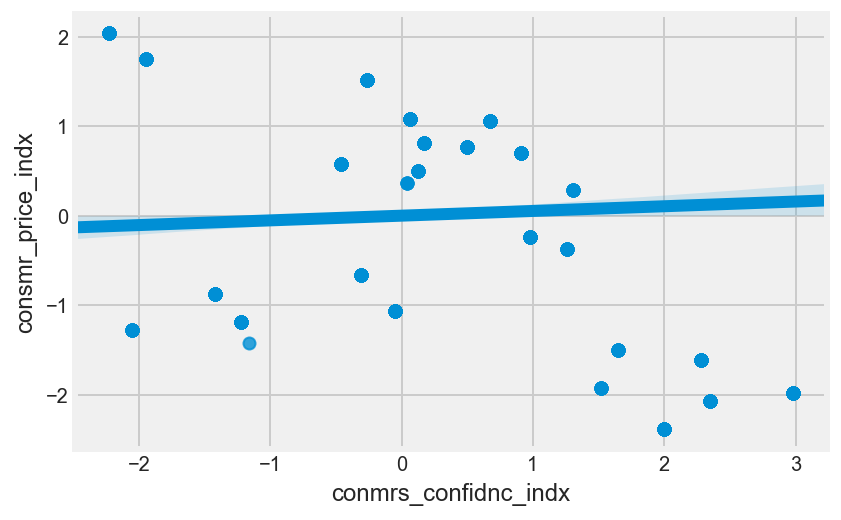

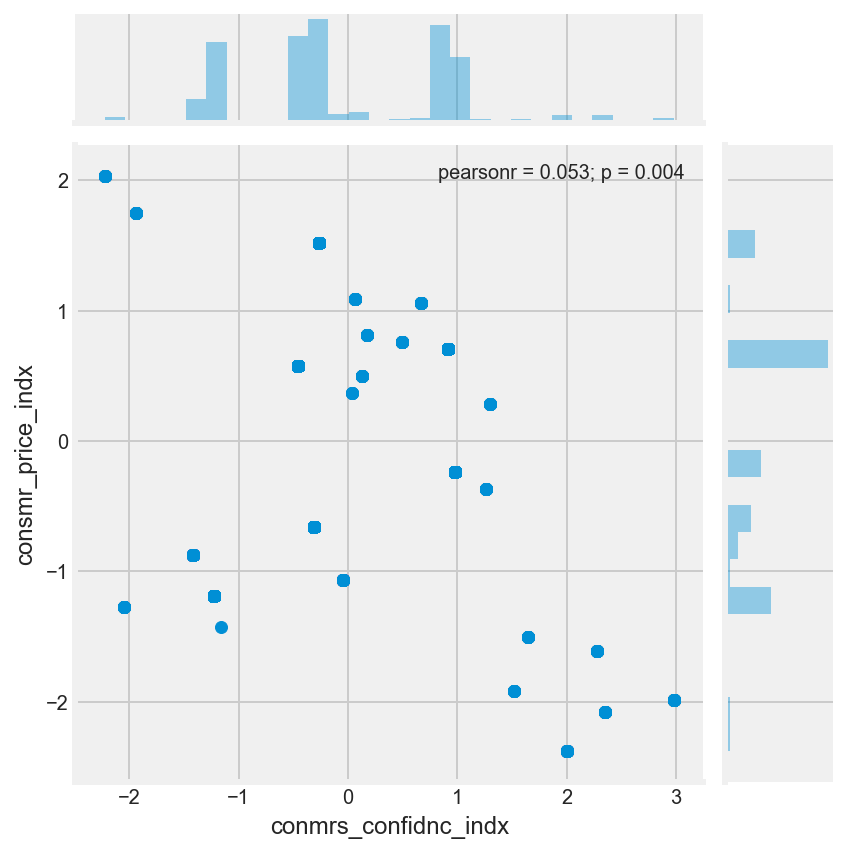

In [60]:
X1 = ["conmrs_confidnc_indx", "consmr_price_indx"]
from mlxtend.preprocessing import standardize
Xs1=standardize(data[X1])
print(Xs1.corr())
print(sns.regplot( Xs1['conmrs_confidnc_indx'], Xs1['consmr_price_indx']))
print(sns.jointplot( Xs1['conmrs_confidnc_indx'], Xs1['consmr_price_indx']))

In [61]:
data.to_csv("data_visualisation" , sep=',', encoding='utf-8')